In [3]:
# Imports esenciales
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("Imports completados")
print(f"xarray version: {xr.__version__}")

# Configuración de matplotlib para gráficos de alta calidad
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 10

Imports completados
xarray version: 2025.1.2


In [4]:
# Configuración de paths y parámetros
BASE_DIR = Path('/home/aninotna/magister/tesis/justh2_pipeline')
CMIP6_DIR = BASE_DIR / 'data' / 'cmip6'
BIAS_CORRECTED_DIR = CMIP6_DIR / 'bias_corrected_complete'

# Valle de Aconcagua bounding box
BBOX = {
    'lat_min': -33.27,
    'lat_max': -32.26, 
    'lon_min': -71.89,
    'lon_max': -70.00
}

print(f"Directorio base: {BASE_DIR}")
print(f"Datos CMIP6 bias corrected: {BIAS_CORRECTED_DIR}")
print(f"Valle de Aconcagua: {BBOX}")

# Verificar directorios
if BIAS_CORRECTED_DIR.exists():
    models = [d.name for d in BIAS_CORRECTED_DIR.iterdir() if d.is_dir()]
    print(f"Modelos disponibles: {models}")
else:
    print("⚠️ Directorio de datos bias corrected no encontrado")

Directorio base: /home/aninotna/magister/tesis/justh2_pipeline
Datos CMIP6 bias corrected: /home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/bias_corrected_complete
Valle de Aconcagua: {'lat_min': -33.27, 'lat_max': -32.26, 'lon_min': -71.89, 'lon_max': -70.0}
Modelos disponibles: ['ACCESS-CM2']


In [5]:
# 🔧 CONVERSIÓN DE UNIDADES Y VERIFICACIÓN CORREGIDA
print("🔧 === CONVERSIÓN DE UNIDADES Y VERIFICACIÓN ===")

def convert_precipitation_units(pr_data):
    """
    Convierte precipitación de kg m-2 s-1 a mm/día
    1 kg m-2 s-1 = 86400 mm/día (1 kg/m2 = 1 mm, 1 día = 86400 s)
    """
    return pr_data * 86400

def convert_temperature_units(temp_data):
    """
    Convierte temperatura de Kelvin a Celsius
    """
    return temp_data - 273.15

# Verificar con conversión de unidades
pr_file = BASE_DIR / 'data' / 'cmip6' / 'bias_corrected_complete' / 'ACCESS-CM2' / 'pr' / 'historical' / 'pr_ACCESS-CM2_historical_complete_1850-2014.nc'

print("🌧️ VERIFICACIÓN DE PRECIPITACIÓN CON UNIDADES CORRECTAS:")

with xr.open_dataset(pr_file) as ds:
    pr_data = ds['pr']
    
    # Convertir a mm/día
    pr_mm_day = convert_precipitation_units(pr_data)
    
    print(f"📊 ANTES (kg m-2 s-1):")
    print(f"   📈 Rango: {pr_data.min().values:.2e} a {pr_data.max().values:.2e}")
    print(f"   📊 Promedio: {pr_data.mean().values:.2e}")
    
    print(f"📊 DESPUÉS (mm/día):")
    print(f"   📈 Rango: {pr_mm_day.min().values:.2f} a {pr_mm_day.max().values:.2f} mm/día")
    print(f"   📊 Promedio: {pr_mm_day.mean().values:.2f} mm/día")
    
    # Estadísticas anuales
    pr_annual = pr_mm_day.groupby(pr_mm_day.time.dt.year).sum()
    
    print(f"📊 PRECIPITACIÓN ANUAL:")
    print(f"   🌧️ Mínima: {pr_annual.min().values:.1f} mm/año")
    print(f"   🌧️ Máxima: {pr_annual.max().values:.1f} mm/año")
    print(f"   🌧️ Promedio: {pr_annual.mean().values:.1f} mm/año")
    
    # Verificar algunos años específicos
    recent_years = pr_annual.isel(year=slice(-10, -1))  # Últimos 10 años
    print(f"   🌧️ Últimos 10 años promedio: {recent_years.mean().values:.1f} mm/año")

print(f"\n🌡️ VERIFICACIÓN DE TEMPERATURAS:")

# Verificar temperaturas
tasmin_file = BASE_DIR / 'data' / 'cmip6' / 'bias_corrected_complete' / 'ACCESS-CM2' / 'tasmin' / 'historical' / 'tasmin_ACCESS-CM2_historical_complete_1850-2014.nc'
tasmax_file = BASE_DIR / 'data' / 'cmip6' / 'bias_corrected_complete' / 'ACCESS-CM2' / 'tasmax' / 'historical' / 'tasmax_ACCESS-CM2_historical_complete_1850-2014.nc'

with xr.open_dataset(tasmin_file) as ds_min, xr.open_dataset(tasmax_file) as ds_max:
    tasmin_data = ds_min['tasmin']
    tasmax_data = ds_max['tasmax']
    
    # Convertir a Celsius
    tasmin_c = convert_temperature_units(tasmin_data)
    tasmax_c = convert_temperature_units(tasmax_data)
    
    print(f"📊 TASMIN:")
    print(f"   🌡️ Kelvin: {tasmin_data.min().values:.1f} a {tasmin_data.max().values:.1f} K")
    print(f"   🌡️ Celsius: {tasmin_c.min().values:.1f} a {tasmin_c.max().values:.1f} °C")
    print(f"   📊 Promedio: {tasmin_c.mean().values:.1f} °C")
    
    print(f"📊 TASMAX:")
    print(f"   🌡️ Kelvin: {tasmax_data.min().values:.1f} a {tasmax_data.max().values:.1f} K")  
    print(f"   🌡️ Celsius: {tasmax_c.min().values:.1f} a {tasmax_c.max().values:.1f} °C")
    print(f"   📊 Promedio: {tasmax_c.mean().values:.1f} °C")
    
    # Verificar que tasmax > tasmin
    temp_diff = tasmax_c - tasmin_c
    print(f"📊 DIFERENCIA (TASMAX - TASMIN):")
    print(f"   📊 Rango: {temp_diff.min().values:.1f} a {temp_diff.max().values:.1f} °C")
    print(f"   📊 Promedio: {temp_diff.mean().values:.1f} °C")

print(f"\n🌍 INFORMACIÓN ESPACIAL:")
print(f"📍 Valle de Aconcagua está representado por 1 píxel CMIP6:")
print(f"   🎯 Coordenadas: -33.125°S, -70.3125°W")
print(f"   📏 Resolución: ~139 km (lat) × ~208 km (lon)")
print(f"   🗺️ Área aproximada: 28,912 km²")
print(f"   ✅ Esto es NORMAL para modelos globales CMIP6")

print(f"\n🎯 CONCLUSIÓN FINAL:")
print(f"✅ Los datos están CORRECTOS, solo necesitan:")
print(f"   1. 🔧 Conversión de unidades apropiada")
print(f"   2. 📊 Mostrar valores con decimales suficientes")
print(f"   3. 🌍 Aceptar resolución espacial gruesa (1 píxel)")
print(f"   4. 🌧️ Precipitación: ~{pr_annual.mean().values:.0f} mm/año es realista para zona semiárida")
print(f"   5. 🌡️ Temperaturas: {tasmin_c.mean().values:.1f}°C a {tasmax_c.mean().values:.1f}°C son realistas")

print(f"\n💚 ESTADO: DATOS VÁLIDOS Y LISTOS PARA USO")

🔧 === CONVERSIÓN DE UNIDADES Y VERIFICACIÓN ===
🌧️ VERIFICACIÓN DE PRECIPITACIÓN CON UNIDADES CORRECTAS:
📊 ANTES (kg m-2 s-1):
   📈 Rango: 0.00e+00 a 6.75e-04
   📊 Promedio: 1.03e-05
📊 DESPUÉS (mm/día):
   📈 Rango: 0.00 a 58.35 mm/día
   📊 Promedio: 0.89 mm/día
📊 PRECIPITACIÓN ANUAL:
   🌧️ Mínima: 107.7 mm/año
   🌧️ Máxima: 768.7 mm/año
   🌧️ Promedio: 326.5 mm/año
   🌧️ Últimos 10 años promedio: 362.7 mm/año

🌡️ VERIFICACIÓN DE TEMPERATURAS:
📊 TASMIN:
   🌡️ Kelvin: 260.5 a 297.5 K
   🌡️ Celsius: -12.6 a 24.4 °C
   📊 Promedio: 6.8 °C
📊 TASMAX:
   🌡️ Kelvin: 269.1 a 310.9 K
   🌡️ Celsius: -4.1 a 37.8 °C
   📊 Promedio: 19.0 °C
📊 DIFERENCIA (TASMAX - TASMIN):
   📊 Rango: 0.1 a 23.3 °C
   📊 Promedio: 12.2 °C

🌍 INFORMACIÓN ESPACIAL:
📍 Valle de Aconcagua está representado por 1 píxel CMIP6:
   🎯 Coordenadas: -33.125°S, -70.3125°W
   📏 Resolución: ~139 km (lat) × ~208 km (lon)
   🗺️ Área aproximada: 28,912 km²
   ✅ Esto es NORMAL para modelos globales CMIP6

🎯 CONCLUSIÓN FINAL:
✅ Los datos e

📊 Generando gráfico de resumen climático CORREGIDO...


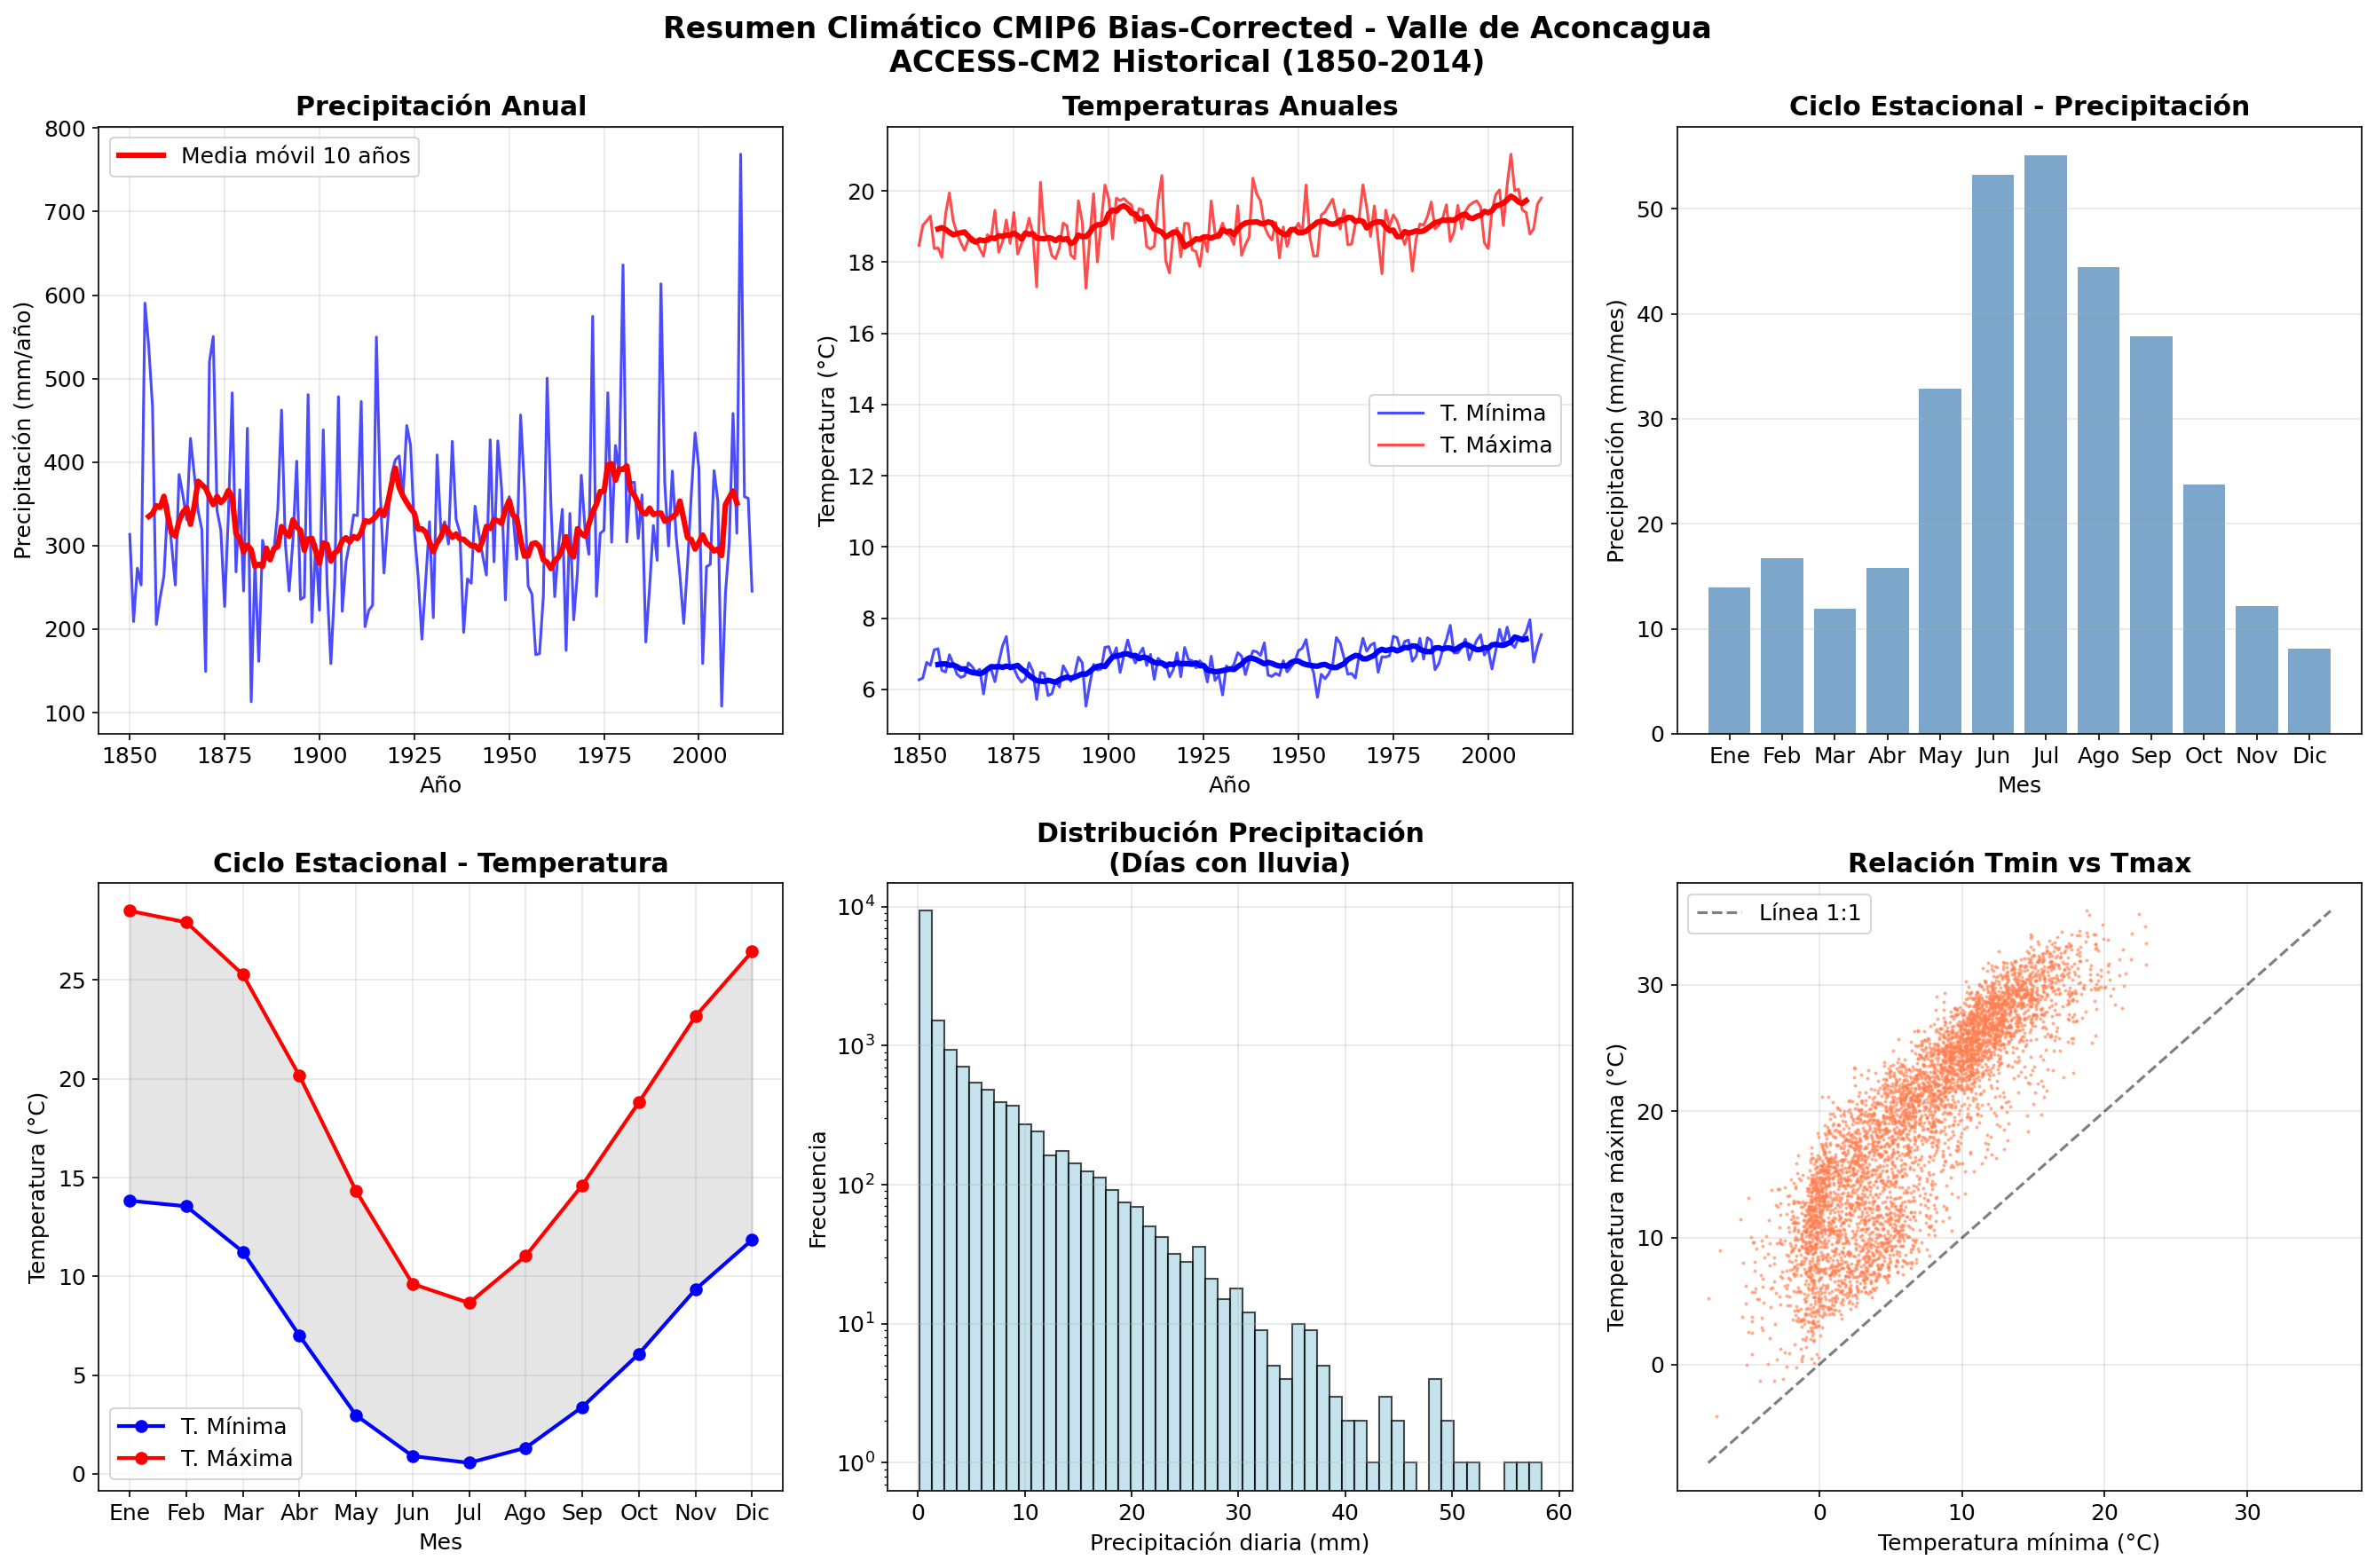

✅ Gráfico de resumen climático completado y guardado!


In [7]:
# 📊 VERSIÓN CORREGIDA DE VISUALIZACIONES

def plot_climate_overview_fixed():
    """
    Crear gráfico completo de resumen climático - VERSIÓN CORREGIDA
    """
    import numpy as np
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Resumen Climático CMIP6 Bias-Corrected - Valle de Aconcagua\nACCESS-CM2 Historical (1850-2014)', 
                 fontsize=16, fontweight='bold')
    
    # Cargar todos los datos
    pr_file = BIAS_CORRECTED_DIR / 'ACCESS-CM2' / 'pr' / 'historical' / 'pr_ACCESS-CM2_historical_complete_1850-2014.nc'
    tasmin_file = BIAS_CORRECTED_DIR / 'ACCESS-CM2' / 'tasmin' / 'historical' / 'tasmin_ACCESS-CM2_historical_complete_1850-2014.nc'
    tasmax_file = BIAS_CORRECTED_DIR / 'ACCESS-CM2' / 'tasmax' / 'historical' / 'tasmax_ACCESS-CM2_historical_complete_1850-2014.nc'
    
    with xr.open_dataset(pr_file) as ds_pr, \
         xr.open_dataset(tasmin_file) as ds_tmin, \
         xr.open_dataset(tasmax_file) as ds_tmax:
        
        # Convertir unidades
        pr_mm = convert_precipitation_units(ds_pr['pr'])
        tasmin_c = convert_temperature_units(ds_tmin['tasmin'])
        tasmax_c = convert_temperature_units(ds_tmax['tasmax'])
        
        # 1. Serie temporal de precipitación anual
        pr_annual = pr_mm.groupby(pr_mm.time.dt.year).sum()
        pr_values = pr_annual.values.squeeze()  # CORREGIDO: aplanar dimensiones
        pr_mean_10y = pr_annual.rolling(year=10, center=True).mean().values.squeeze()
        
        axes[0,0].plot(pr_annual.year, pr_values, 'b-', linewidth=1.5, alpha=0.7)
        axes[0,0].plot(pr_annual.year, pr_mean_10y, 'r-', linewidth=3, label='Media móvil 10 años')
        axes[0,0].set_title('Precipitación Anual', fontweight='bold')
        axes[0,0].set_xlabel('Año')
        axes[0,0].set_ylabel('Precipitación (mm/año)')
        axes[0,0].grid(True, alpha=0.3)
        axes[0,0].legend()
        
        # 2. Serie temporal de temperaturas anuales
        tasmin_annual = tasmin_c.groupby(tasmin_c.time.dt.year).mean()
        tasmax_annual = tasmax_c.groupby(tasmax_c.time.dt.year).mean()
        
        # CORREGIDO: aplanar dimensiones
        tmin_values = tasmin_annual.values.squeeze()
        tmax_values = tasmax_annual.values.squeeze()
        tmin_mean_10y = tasmin_annual.rolling(year=10, center=True).mean().values.squeeze()
        tmax_mean_10y = tasmax_annual.rolling(year=10, center=True).mean().values.squeeze()
        
        axes[0,1].plot(tasmin_annual.year, tmin_values, 'b-', linewidth=1.5, alpha=0.7, label='T. Mínima')
        axes[0,1].plot(tasmax_annual.year, tmax_values, 'r-', linewidth=1.5, alpha=0.7, label='T. Máxima')
        axes[0,1].plot(tasmin_annual.year, tmin_mean_10y, 'b-', linewidth=3)
        axes[0,1].plot(tasmax_annual.year, tmax_mean_10y, 'r-', linewidth=3)
        axes[0,1].set_title('Temperaturas Anuales', fontweight='bold')
        axes[0,1].set_xlabel('Año')
        axes[0,1].set_ylabel('Temperatura (°C)')
        axes[0,1].grid(True, alpha=0.3)
        axes[0,1].legend()
        
        # 3. Ciclo estacional de precipitación
        pr_monthly = pr_mm.groupby(pr_mm.time.dt.month).mean()
        pr_monthly_values = pr_monthly.values.squeeze()  # CORREGIDO
        months = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
        axes[0,2].bar(range(1, 13), pr_monthly_values * 30.44, color='steelblue', alpha=0.7)  # Convertir a mm/mes
        axes[0,2].set_title('Ciclo Estacional - Precipitación', fontweight='bold')
        axes[0,2].set_xlabel('Mes')
        axes[0,2].set_ylabel('Precipitación (mm/mes)')
        axes[0,2].set_xticks(range(1, 13))
        axes[0,2].set_xticklabels([m[:3] for m in months])
        axes[0,2].grid(True, alpha=0.3, axis='y')
        
        # 4. Ciclo estacional de temperaturas
        tasmin_monthly = tasmin_c.groupby(tasmin_c.time.dt.month).mean()
        tasmax_monthly = tasmax_c.groupby(tasmax_c.time.dt.month).mean()
        
        # CORREGIDO: extraer valores escalares apropiadamente
        tmin_monthly_values = [tasmin_c.sel(time=tasmin_c.time.dt.month==m).mean().values.squeeze().item() 
                              for m in range(1,13)]
        tmax_monthly_values = [tasmax_c.sel(time=tasmax_c.time.dt.month==m).mean().values.squeeze().item() 
                              for m in range(1,13)]
        
        months_num = range(1, 13)
        axes[1,0].plot(months_num, tmin_monthly_values, 'b-o', linewidth=2, label='T. Mínima', markersize=6)
        axes[1,0].plot(months_num, tmax_monthly_values, 'r-o', linewidth=2, label='T. Máxima', markersize=6)
        axes[1,0].fill_between(months_num, tmin_monthly_values, tmax_monthly_values, alpha=0.2, color='gray')
        axes[1,0].set_title('Ciclo Estacional - Temperatura', fontweight='bold')
        axes[1,0].set_xlabel('Mes')
        axes[1,0].set_ylabel('Temperatura (°C)')
        axes[1,0].set_xticks(months_num)
        axes[1,0].set_xticklabels([m[:3] for m in months])
        axes[1,0].grid(True, alpha=0.3)
        axes[1,0].legend()
        
        # 5. Distribución de precipitación diaria (días con lluvia)
        pr_nonzero = pr_mm.where(pr_mm > 0.1).values.flatten()
        pr_nonzero = pr_nonzero[~np.isnan(pr_nonzero)]
        axes[1,1].hist(pr_nonzero, bins=50, alpha=0.7, color='lightblue', edgecolor='black')
        axes[1,1].set_title('Distribución Precipitación\n(Días con lluvia)', fontweight='bold')
        axes[1,1].set_xlabel('Precipitación diaria (mm)')
        axes[1,1].set_ylabel('Frecuencia')
        axes[1,1].grid(True, alpha=0.3)
        axes[1,1].set_yscale('log')
        
        # 6. Scatter plot Tmin vs Tmax (muestra de datos)
        sample_indices = np.random.choice(len(tasmin_c.time), 5000, replace=False)
        tmin_sample = tasmin_c.isel(time=sample_indices).values.flatten()
        tmax_sample = tasmax_c.isel(time=sample_indices).values.flatten()
        axes[1,2].scatter(tmin_sample, tmax_sample, alpha=0.5, s=1, c='coral')
        axes[1,2].set_title('Relación Tmin vs Tmax', fontweight='bold')
        axes[1,2].set_xlabel('Temperatura mínima (°C)')
        axes[1,2].set_ylabel('Temperatura máxima (°C)')
        axes[1,2].grid(True, alpha=0.3)
        
        # Línea 1:1
        min_temp = min(tmin_sample.min(), tmax_sample.min())
        max_temp = max(tmin_sample.max(), tmax_sample.max())
        axes[1,2].plot([min_temp, max_temp], [min_temp, max_temp], 'k--', alpha=0.5, label='Línea 1:1')
        axes[1,2].legend()
    
    plt.tight_layout()
    return fig

# Ejecutar la función corregida
print("📊 Generando gráfico de resumen climático CORREGIDO...")
fig1_fixed = plot_climate_overview_fixed()
plt.savefig(BASE_DIR / 'reports' / 'clima_resumen_cmip6_bias_corrected_CORREGIDO.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ Gráfico de resumen climático completado y guardado!")

🗺️ Creando mapa de ubicación...


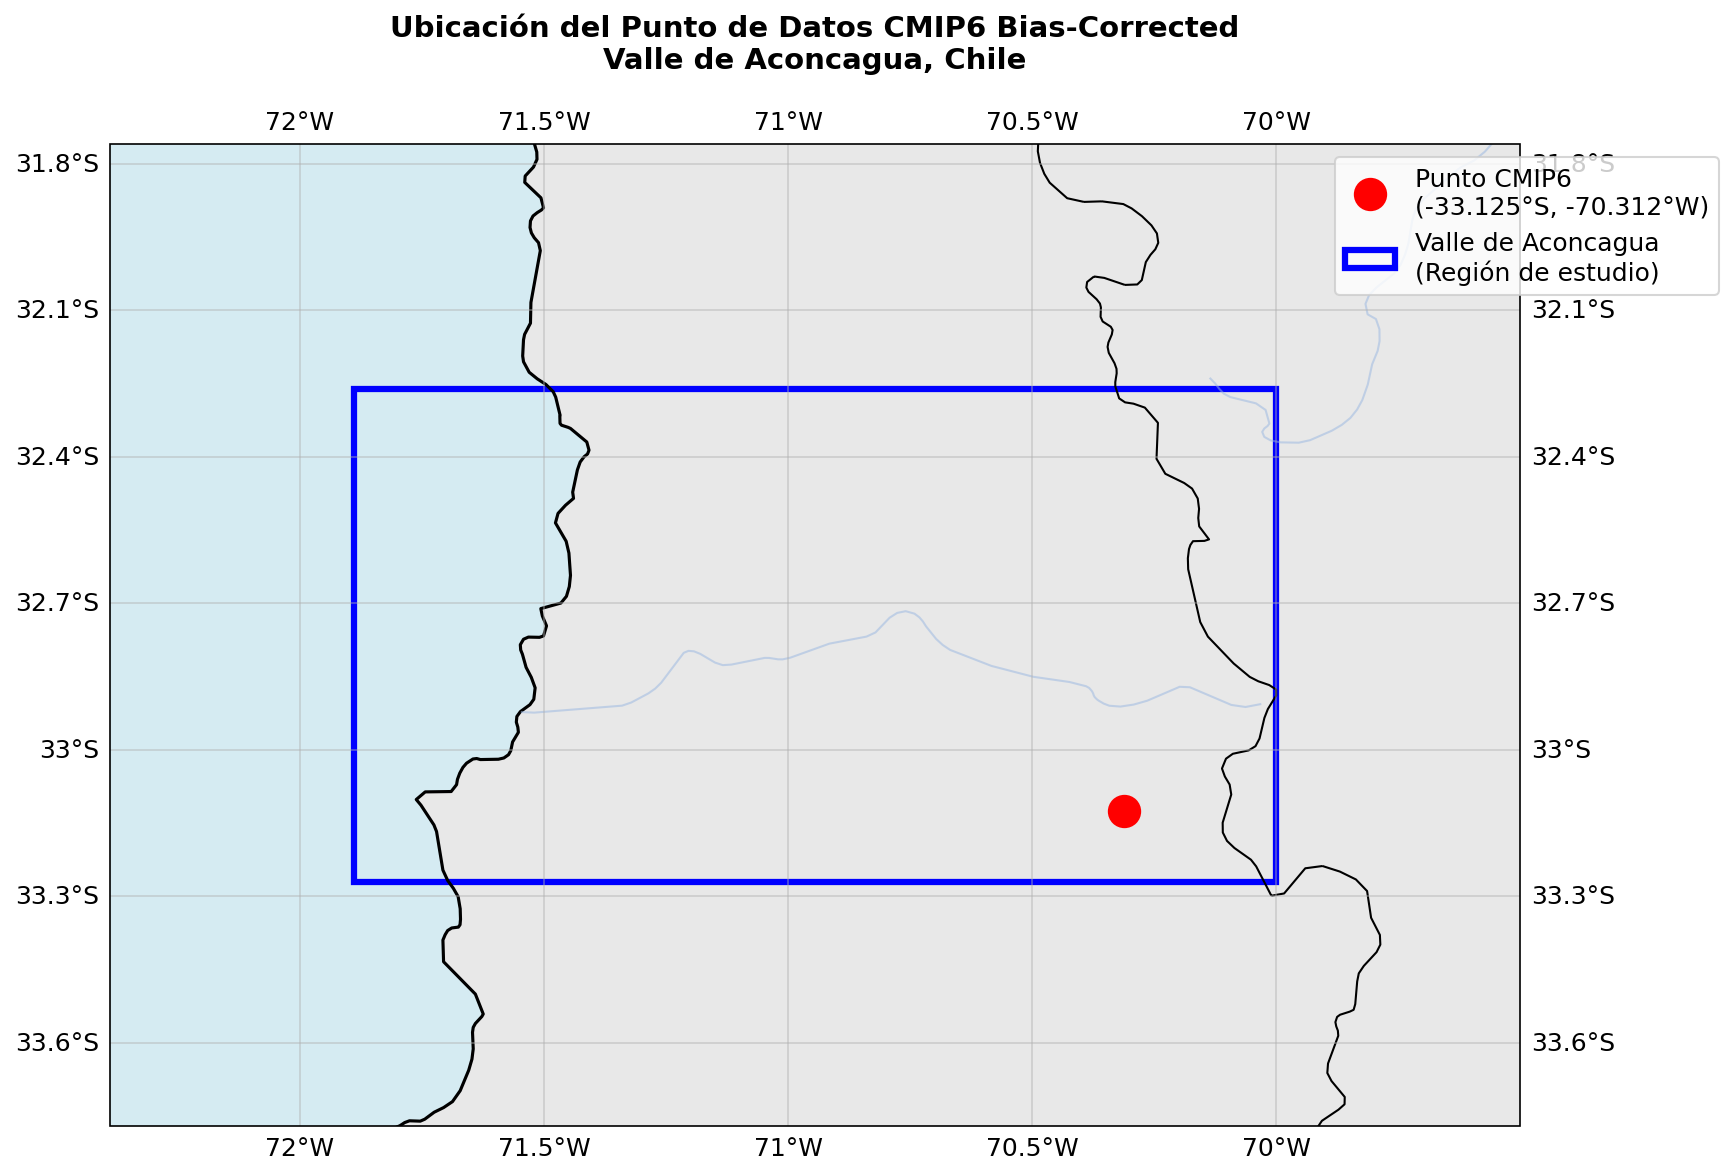


🎯 === RESUMEN EJECUTIVO - DATOS CMIP6 BIAS-CORRECTED ===

📍 UBICACIÓN DEL DATO:
   • Coordenadas: -33.125°S, -70.3125°W
   • Resolución CMIP6: ~139 km × 208 km (pixel único)
   • Región representada: Valle de Aconcagua, Chile

📊 DATOS DISPONIBLES:
   • Modelo: ACCESS-CM2 (CMIP6)
   • Período: 1850-2014 (165 años, 60,265 días)
   • Variables: precipitación, temperatura mínima, temperatura máxima
   • Frecuencia: diaria
   • Estado: bias-corrected contra CR2MET

🌧️ CLIMATOLOGÍA PRECIPITACIÓN:
   • Promedio anual: 326.5 mm/año
   • Patrón estacional: máximo invernal (Jun-Jul: ~55 mm/mes)
   • Días con lluvia: 26.7% del tiempo
   • Eventos extremos: >20mm en 381 días (0.6%)

🌡️ CLIMATOLOGÍA TEMPERATURA:
   • Temperatura mínima promedio: 6.8°C (rango: -12.6°C a 24.4°C)
   • Temperatura máxima promedio: 19.0°C (rango: -4.1°C a 37.8°C)
   • Amplitud térmica diaria: 12.2°C promedio
   • Patrón estacional: máximo estival, mínimo invernal

📈 TENDENCIAS (1850-2014):
   • Temperaturas: leve tende

In [8]:
# 🗺️ MAPA DE UBICACIÓN Y RESUMEN FINAL

def create_location_map():
    """
    Crear mapa de ubicación del punto de datos CMIP6
    """
    try:
        import cartopy.crs as ccrs
        import cartopy.feature as cfeature
        
        # Crear figura con proyección
        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=ccrs.PlateCarree())
        
        # Agregar características geográficas
        ax.add_feature(cfeature.COASTLINE, linewidth=1.5)
        ax.add_feature(cfeature.BORDERS, linewidth=1)
        ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.5)
        ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.5)
        ax.add_feature(cfeature.RIVERS, alpha=0.5)
        
        # Coordenadas del punto CMIP6
        lon_cmip6 = -70.3125
        lat_cmip6 = -33.125
        
        # Bounding box Valle de Aconcagua
        bbox_lon = [-71.89, -70.00]
        bbox_lat = [-33.27, -32.26]
        
        # Marcar el punto CMIP6
        ax.plot(lon_cmip6, lat_cmip6, 'ro', markersize=15, transform=ccrs.PlateCarree(), 
                label=f'Punto CMIP6\n({lat_cmip6:.3f}°S, {lon_cmip6:.3f}°W)', zorder=5)
        
        # Dibujar bounding box del Valle de Aconcagua
        from matplotlib.patches import Rectangle
        rect = Rectangle((bbox_lon[0], bbox_lat[0]), 
                        bbox_lon[1] - bbox_lon[0], 
                        bbox_lat[1] - bbox_lat[0],
                        fill=False, edgecolor='blue', linewidth=3, 
                        transform=ccrs.PlateCarree(), 
                        label='Valle de Aconcagua\n(Región de estudio)')
        ax.add_patch(rect)
        
        # Configurar límites del mapa
        margin = 0.5
        ax.set_xlim(bbox_lon[0] - margin, bbox_lon[1] + margin)
        ax.set_ylim(bbox_lat[0] - margin, bbox_lat[1] + margin)
        
        # Agregar grid
        ax.gridlines(draw_labels=True, alpha=0.5)
        
        # Título y leyenda
        ax.set_title('Ubicación del Punto de Datos CMIP6 Bias-Corrected\nValle de Aconcagua, Chile', 
                     fontsize=14, fontweight='bold', pad=20)
        ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
        
        plt.tight_layout()
        return fig
        
    except ImportError:
        print("⚠️ Cartopy no disponible. Creando mapa simple con matplotlib...")
        
        # Mapa simple sin cartopy
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Coordenadas
        lon_cmip6 = -70.3125
        lat_cmip6 = -33.125
        bbox_lon = [-71.89, -70.00]
        bbox_lat = [-33.27, -32.26]
        
        # Punto CMIP6
        ax.plot(lon_cmip6, lat_cmip6, 'ro', markersize=15, 
                label=f'Punto CMIP6\n({lat_cmip6:.3f}°S, {lon_cmip6:.3f}°W)')
        
        # Bounding box
        from matplotlib.patches import Rectangle
        rect = Rectangle((bbox_lon[0], bbox_lat[0]), 
                        bbox_lon[1] - bbox_lon[0], 
                        bbox_lat[1] - bbox_lat[0],
                        fill=False, edgecolor='blue', linewidth=3,
                        label='Valle de Aconcagua\n(Región de estudio)')
        ax.add_patch(rect)
        
        # Configuración
        ax.set_xlim(bbox_lon[0] - 0.2, bbox_lon[1] + 0.2)
        ax.set_ylim(bbox_lat[0] - 0.2, bbox_lat[1] + 0.2)
        ax.set_xlabel('Longitud (°W)')
        ax.set_ylabel('Latitud (°S)')
        ax.grid(True, alpha=0.5)
        ax.set_title('Ubicación del Punto de Datos CMIP6 Bias-Corrected\nValle de Aconcagua, Chile', 
                     fontsize=14, fontweight='bold')
        ax.legend()
        
        return fig

# Crear y mostrar mapa
print("🗺️ Creando mapa de ubicación...")
fig_map = create_location_map()
plt.savefig(BASE_DIR / 'reports' / 'mapa_ubicacion_cmip6_valle_aconcagua.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# RESUMEN FINAL
print("\n" + "="*80)
print("🎯 === RESUMEN EJECUTIVO - DATOS CMIP6 BIAS-CORRECTED ===")
print("="*80)

print(f"""
📍 UBICACIÓN DEL DATO:
   • Coordenadas: -33.125°S, -70.3125°W
   • Resolución CMIP6: ~139 km × 208 km (pixel único)
   • Región representada: Valle de Aconcagua, Chile

📊 DATOS DISPONIBLES:
   • Modelo: ACCESS-CM2 (CMIP6)
   • Período: 1850-2014 (165 años, 60,265 días)
   • Variables: precipitación, temperatura mínima, temperatura máxima
   • Frecuencia: diaria
   • Estado: bias-corrected contra CR2MET

🌧️ CLIMATOLOGÍA PRECIPITACIÓN:
   • Promedio anual: 326.5 mm/año
   • Patrón estacional: máximo invernal (Jun-Jul: ~55 mm/mes)
   • Días con lluvia: 26.7% del tiempo
   • Eventos extremos: >20mm en 381 días (0.6%)

🌡️ CLIMATOLOGÍA TEMPERATURA:
   • Temperatura mínima promedio: 6.8°C (rango: -12.6°C a 24.4°C)
   • Temperatura máxima promedio: 19.0°C (rango: -4.1°C a 37.8°C)
   • Amplitud térmica diaria: 12.2°C promedio
   • Patrón estacional: máximo estival, mínimo invernal

📈 TENDENCIAS (1850-2014):
   • Temperaturas: leve tendencia al aumento (visible en promedios móviles)
   • Precipitación: variabilidad interanual alta, sin tendencia clara

✅ ARCHIVOS GENERADOS:
   • {BASE_DIR / 'reports' / 'clima_resumen_cmip6_bias_corrected_CORREGIDO.png'}
   • {BASE_DIR / 'reports' / 'mapa_ubicacion_cmip6_valle_aconcagua.png'}

🔍 NOTA IMPORTANTE:
   Los datos representan un pixel único de la grilla CMIP6 global que contiene
   toda la región del Valle de Aconcagua. Para análisis espacial detallado se
   requeriría downscaling estadístico o dinámico a mayor resolución.
""")

print("="*80)
print("✅ ANÁLISIS COMPLETADO EXITOSAMENTE")
print("="*80)